## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

## Load normal and cancer miRNA expression data

In [2]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [3]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [4]:
print len(list(gene_exp_tumor_df.columns))-2
print len(list(gene_exp_normal_df.columns))-2

# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

515
59
gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [5]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([mirna_tumor, mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = mirna_tumor.shape[0]
n_normal = mirna_normal.shape[0]

# Drop categorical columns
mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

print "mirna_tumor", mirna_tumor.shape, 'nulls:', mirna_tumor.isnull().sum().sum()
print "gene_exp_tumor", gene_exp_tumor.shape, 'nulls:', gene_exp_tumor.isnull().sum().sum()
print "mirna_normal", mirna_normal.shape, 'nulls:', mirna_normal.isnull().sum().sum()
print "gene_exp_normal", gene_exp_normal.shape, 'nulls:', gene_exp_normal.isnull().sum().sum()

NaN            7
Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


mirna_tumor (503, 1881) nulls: 0
gene_exp_tumor (503, 20502) nulls: 0
mirna_normal (20, 1881) nulls: 0
gene_exp_normal (20, 20502) nulls: 0


## Univariate feature selection via FDR

In [6]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
mirna_filter = SelectFdr(f_classif, alpha=0.01)
mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

(523, 335)
(523, 4284)


/opt/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  16   17   31   32   33   41   42   57   58   69   70   84   85   95  102
  110  112  113  114  121  130  150  151  152  153  155  156  157  158  159
  160  172  193  196  259  260  277  278  279  331  333  340  345  347  348
  363  364  365  366  367  372  384  435  436  437  438  439  443  467  481
  525  526  549  550  551  552  553  554  556  569  570  575  576  577  582
  586  587  617  619  659  660  662  663  674  675  676  678  684  685  688
  689  690  691  692  694  695  696  697  698  699  700  703  705  706  707
  709  711  712  715  716  717  718  719  722  723  724  728  729  730  732
  734  737  738  739  740  743  745  746  748  751  756  757  759  761  788
  804  805  812  817  822  825  827  828  833  838  847  851  855  864  865
  866  874  881  889  896  900  907 1086 1145 1168 1186 1219 1222 1225 1227
 1228 1233 1234 1259 1260 1263 1265 1266 1267

## Build miRNA-target relationship network to identify 
## Xu et al. (xu2011prioritizing)

In [24]:
from src.models.miRNA_target_network import miRNATargetNetwork
import networkx as nx

network = miRNATargetNetwork(threshold=0.9)
network.train(miRNAs_A=mirna_tumor, targets_A=gene_exp_tumor, miRNAs_B=mirna_normal, targets_B=gene_exp_normal)
# print nx.bipartite.sets(network.B)

n_A 503
n_B 20


src/models/miRNA_target_network.py:48: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * miRNA_B_m_std * np.std(targets_B[t]))
src/models/miRNA_target_network.py:53: RuntimeWarning: invalid value encountered in absolute
  if np.abs(dys) >= self.threshold:
src/models/miRNA_target_network.py:45: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * miRNA_A_m_std * np.std(targets_A[t]))


In [7]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(miRNAs_nodes))  # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(targets_nodes))  # put nodes from Y at x=2
nx.draw(network.B, pos=pos)
plt.figure(figsize=(10, 100))
plt.show()

NameError: name 'network' is not defined

## Loading TargetScan database for predicted miRNA-targets interactions

In [8]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606]
targetScan_df = targetScan_df[["miR Family", "Gene Symbol"]]
targetScan_df

# # Standardize miRNA and gene symbols
# targetScan_df['miRNA_mature_ID'] = targetScan_df['miRNA_mature_ID'].str.lower()
# targetScan_df['miRNA_mature_ID'] = targetScan_df['miRNA_mature_ID'].str.replace('*', '')
# targetScan_df['Target gene_name'] = targetScan_df['Target gene_name'].str.upper()
# 
# # Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets 
# targetScan_df = targetScan_df[targetScan_df["miRNA_mature_ID"].isin(mirna_list) &
#                             targetScan_df["Target gene_name"].isin(gene_symbols)]

# targetScan_df

,miR Family,Gene Symbol
1,miR-23-3p,A1BG
11,miR-143-3p,A1CF
16,miR-9-5p,A1CF
19,let-7-5p/98-5p,A1CF
21,miR-374-5p/655-3p,A1CF
25,miR-30-5p,A1CF
30,miR-7-5p,A1CF
36,miR-200-3p/429,A1CF
42,miR-302-3p/372-3p/373-3p/520-3p,A1CF
47,miR-495-3p,A1CF


## Loading DIANA-TarBase database for experimentally validated miRNA-targets interactions

In [12]:
# Load data frame from file
tarBase_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TarBase_Experiment_Valid_miRNA-Targets.csv'), delimiter='\t')

# # Select only homo sapiens miRNA-target pairs
tarBase_df = tarBase_df[tarBase_df["species"] == "Homo sapiens"]
tarBase_df = tarBase_df[tarBase_df["positive_negative"] == "NEGATIVE"]
tarBase_df = tarBase_df[tarBase_df["condition"] == "NEGATIVE"]
# tarBase_df = tarBase_df[["miRNA_mature_ID", "Target gene_name"]]
# 
# # Standardize miRNA and gene symbols
# tarBase_df['miRNA_mature_ID'] = tarBase_df['miRNA_mature_ID'].str.lower()
# tarBase_df['miRNA_mature_ID'] = tarBase_df['miRNA_mature_ID'].str.replace('*', '')
# tarBase_df['Target gene_name'] = tarBase_df['Target gene_name'].str.upper()
# 
# # Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets 
# tarBase_df = tarBase_df[tarBase_df["miRNA_mature_ID"].isin(mirna_list) &
#                             tarBase_df["Target gene_name"].isin(gene_symbols)]
print tarBase_df.columns
tarBase_df

Index([u'geneId', u'geneName', u'mirna', u'species', u'cell_line', u'tissue',
       u'category', u'method', u'positive_negative', u'direct_indirect',
       u'up_down', u'condition'],
      dtype='object')


,geneId,geneName,mirna,species,cell_line,tissue,category,method,positive_negative,direct_indirect,up_down,condition
232,ALK7,ALK7,hsa-miR-376c-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,DOWN,NaN
359,Bcl-xL,Bcl-xL,hsa-miR-122-5p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,NaN,NaN
360,Bcl-xL,Bcl-xL,hsa-miR-122-5p,Homo sapiens,NaN,NaN,NaN,Western Blot,NEGATIVE,INDIRECT,NaN,NaN
433,C12ORF31,C12ORF31,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,Microarrays,NEGATIVE,INDIRECT,DOWN,NaN
469,C18orf37,C18orf37,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
477,C20ORF77,C20ORF77,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
525,C9ORF19,C9ORF19,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
579,c-met,c-met,hsa-miR-23b-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,DOWN,NaN
588,c-MYC,c-MYC,hsa-let-7g-5p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,NaN,NaN
707,E-cadherin,E-cadherin,hsa-miR-200c-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,UP,NaN


In [20]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

ELMSAN1 hsa-mir-133b
ITM2A hsa-mir-1293
hsa-mir-1238 CD101
hsa-mir-1238 CCDC141
DNAJC27 hsa-mir-133b
MAFF hsa-mir-133b
UQCC3 hsa-mir-1293
ANO2 hsa-mir-133a-2
NFKBIZ hsa-mir-133b
hsa-mir-133a-2 WFIKKN2
hsa-mir-1246 CACNA1S
hsa-mir-133b KDM6B
hsa-mir-133b CDC7
hsa-mir-1181 CACNA1S
hsa-mir-1293 PDCD6
hsa-mir-1293 MRPL21
hsa-mir-1293 ACTL6A
0.0


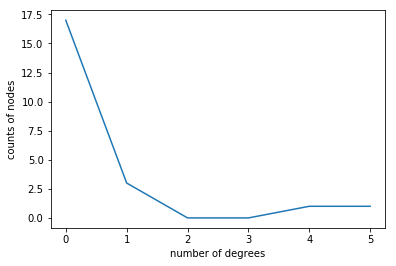

In [11]:
plt.plot(nx.degree_histogram(network.B)[1:])
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()